In [4]:
import pandas as pd
import duckdb

## 0. Setup

In [5]:
conn: duckdb.DuckDBPyConnection = duckdb.connect("paveai.duckdb")

In [6]:
# Create schemas
conn.execute("CREATE SCHEMA IF NOT EXISTS bronze;")
conn.execute("CREATE SCHEMA IF NOT EXISTS sliver;")
conn.execute("CREATE SCHEMA IF NOT EXISTS golden;")

In [7]:
df_damage_reports: pd.DataFrame = pd.read_csv("data/data-engineer/data/damage_reports.csv")
df_inspections: pd.DataFrame = pd.read_csv("data/data-engineer/data/inspections.csv")
df_inspectors: pd.DataFrame = pd.read_csv("data/data-engineer/data/inspectors.csv")
df_vehicles: pd.DataFrame = pd.read_csv("data/data-engineer/data/vehicles.csv")

In [8]:
# Register the DataFrame as a DuckDB view
conn.register('df_damage_reports', df_damage_reports)
conn.register('df_inspections', df_inspections)
conn.register('df_inspectors', df_inspectors)
conn.register('df_vehicles', df_vehicles)

### ERD in OLTP

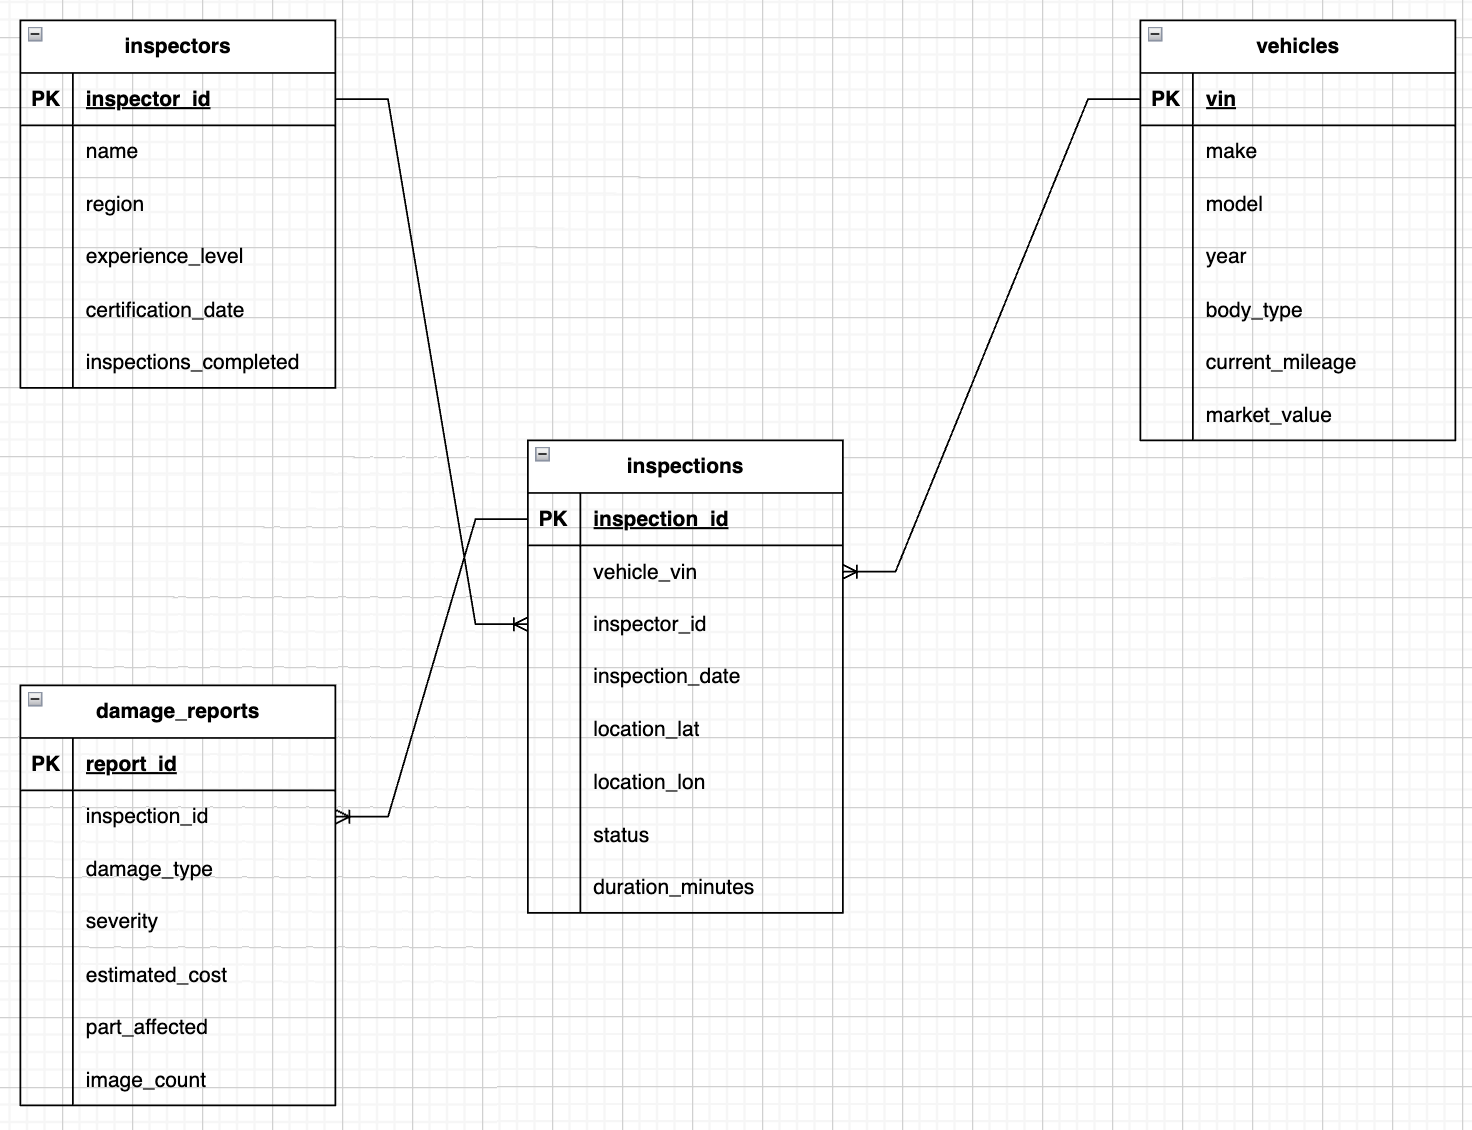

### Data Modeling

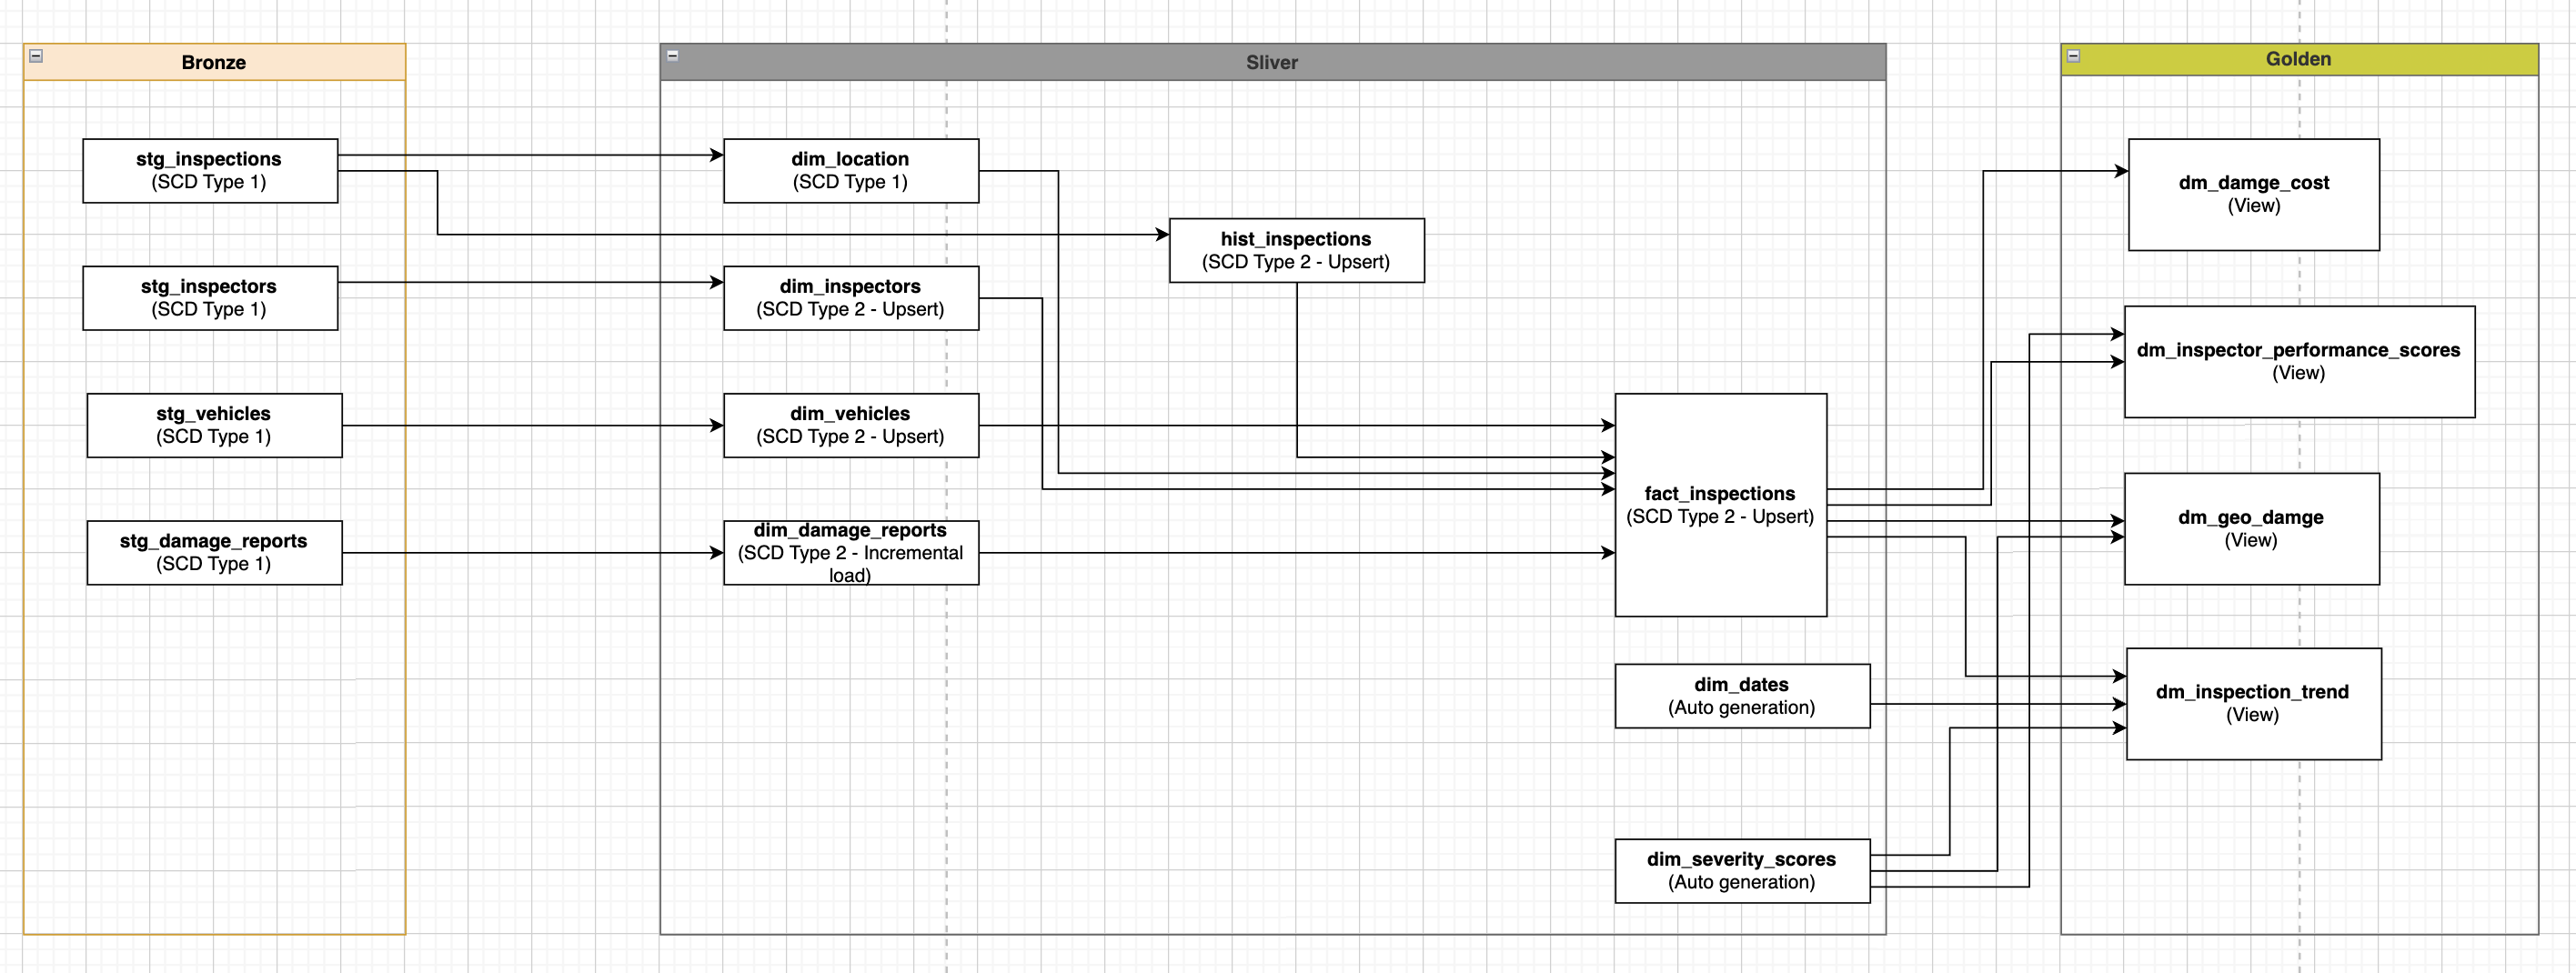

## 1. Bronze layer

Includes all staging tables

In [9]:
# stg_damage_reports, stg_inspections, stg_inspectors, and stg_vehicles are table is SCD type 1 (Full refresh). 
# But in this example, I apply the overwrite method for easy solution.

### stg_damage_reports ###
conn.execute("DROP TABLE IF EXISTS bronze.stg_damage_reports;")
conn.execute("""
    CREATE TABLE bronze.stg_damage_reports AS 
    SELECT 
        *, 
        CURRENT_TIMESTAMP::TIMESTAMP AS "inserted_from" -- Cast to time without timezone
    FROM df_damage_reports;
"""
)

### stg_inspections ###
conn.execute("DROP TABLE IF EXISTS bronze.stg_inspections;")
conn.execute("""
    CREATE TABLE bronze.stg_inspections AS 
    SELECT 
        *,
        SHA256(
            CONCAT_WS(
                '|',
                inspection_date,
                location_lat,
                location_lon,
                status,
                duration_minutes
            )
        ) AS hash_key,
        CURRENT_TIMESTAMP::TIMESTAMP AS "inserted_from" -- Cast to time without timezone
    FROM df_inspections;
"""
)

### stg_inspectors ###
conn.execute("DROP TABLE IF EXISTS bronze.stg_inspectors;")
conn.execute("""
    CREATE TABLE bronze.stg_inspectors AS 
    SELECT 
        *,
        SHA256(
            CONCAT_WS(
                '|',
                name,
                region,
                experience_level,
                certification_date,
                inspections_completed
            )
        ) AS hash_key,
        CURRENT_TIMESTAMP::TIMESTAMP AS "inserted_from" -- Cast to time without timezone
    FROM df_inspectors;
"""
)

### stg_vehicles ###
conn.execute("DROP TABLE IF EXISTS bronze.stg_vehicles;")
conn.execute("""
    CREATE TABLE bronze.stg_vehicles AS 
    SELECT 
        *, 
        SHA256(
            CONCAT_WS(
                '|',
                vin,
                make,
                model,
                year,
                body_type,
                current_mileage,
                market_value
            )
        ) AS hash_key,
        CURRENT_TIMESTAMP::TIMESTAMP AS "inserted_from" -- Cast to time without timezone
    FROM df_vehicles;
"""
)
print("Completed to build tables in bronze layer!")

Completed to build tables in bronze layer!


In [8]:
conn.execute("SELECT * FROM bronze.stg_inspections").fetch_df().head()

,inspection_id,vehicle_vin,inspector_id,inspection_date,location_lat,location_lon,status,duration_minutes,hash_key,inserted_from
0,INSP000001,WKJAAHPMU6PFAAPBE,INS0021,2025-03-17 04:27:58.218272,37.273166,-121.993342,completed,30,4c87f31989d6908854848c6b180001ef9189d88b23008a...,2025-08-07 13:20:33.672
1,INSP000002,IHVI2QDMPBA5S6ERA,INS0021,2024-05-30 20:12:44.236984,33.578106,-112.289045,completed,43,c09ca4c1d6ea7faf550a47a2c55fc4b50d2139a8ef700e...,2025-08-07 13:20:33.672
2,INSP000003,6ZTEFEHX2BT869595,INS0004,2024-01-11 08:28:17.114703,37.415610,-122.008271,completed,25,b585f5ca29204382a2a359825a5be426ee6b353ff7ac84...,2025-08-07 13:20:33.672
3,INSP000004,7DKEH1SDIZKA1OZK2,INS0012,2023-12-21 12:32:44.853435,29.726827,-95.480103,pending_review,35,6b7cee0cf30ce56634df63303e8dde03d5cd5f4757bf70...,2025-08-07 13:20:33.672
4,INSP000005,UZL8NWLXHUMLBQG0G,INS0021,2024-05-24 16:48:49.415062,40.772695,-74.034072,completed,46,607d7805ad578151f00075e2442b3d6ca458999241aeea...,2025-08-07 13:20:33.672


In [9]:
conn.execute("SELECT * FROM bronze.stg_vehicles").fetch_df().head()

,vin,make,model,year,body_type,current_mileage,market_value,hash_key,inserted_from
0,GZMIWGFQUIKW3XL8C,Kia,Sorento,2022,Convertible,134564,48608,8c2be6ae7dc79bb0b107dfff2bed7e6d3d9647bc727316...,2025-08-07 13:20:33.687
1,MSME53UD5BVHQVG9Q,Kia,Sorento,2010,Coupe,27859,-3523,25fc9e1d28d9616aed381590f75ebfa1e3e62741a7acd9...,2025-08-07 13:20:33.687
2,23C4DX76V6A0LHLOG,Hyundai,Santa Fe,2016,Van,119378,11322,3dde26d5689106629dfdcb0b6a25298c1c5784f17d104d...,2025-08-07 13:20:33.687
3,WSQL4TXZ9QQ9BTF1T,Mercedes-Benz,GLE,2015,Hatchback,41071,4915,a501c40de261ecdc36e43d9ea63902780ba871393625c4...,2025-08-07 13:20:33.687
4,EVO2249GGWEYW7MIO,Mercedes-Benz,C-Class,2016,Hatchback,80976,19147,2f23f80cf1cf61b16ddfb36711a7952c6a76c561f0a862...,2025-08-07 13:20:33.687


## 2. Sliver

### dim_severity_scores (Auto generation)

That tabe was built by my assumption. Its role like mapping data to calculate the severity scores.

In [15]:
conn.execute("DROP TABLE IF EXISTS sliver.dim_severity_scores")

conn.execute("""
CREATE TABLE sliver.dim_severity_scores (
  severity_sk INTEGER PRIMARY KEY,
  severity_label TEXT UNIQUE,
  severity_score INT
);
""")


conn.execute("""
WITH new_scores AS (
  SELECT * FROM (VALUES
    ('Paint Damage', 1),
    ('Scratch', 2),
    ('Dent', 2),
    ('Rust', 3),
    ('Broken Glass', 4),
    ('Frame Damage', 5)
  ) AS t(severity_label, severity_score)
),
numbered AS (
  SELECT
    ROW_NUMBER() OVER () + COALESCE((SELECT MAX(severity_sk) FROM sliver.dim_severity_scores), 0) AS severity_sk,
    *
  FROM new_scores
)
INSERT INTO sliver.dim_severity_scores
SELECT * FROM numbered;
""")

### dim_location (SCD type 1 - Full refresh)

In [20]:
# First build
conn.execute("DROP TABLE IF EXISTS sliver.dim_location;")
conn.execute("""
    CREATE TABLE sliver.dim_location AS
    SELECT
        location_lat AS lat,
        location_lon AS lon,
        inspection_id
    FROM (
        SELECT DISTINCT 
            location_lat, 
            location_lon,
            inspection_id
        FROM 
            bronze.stg_inspections
        WHERE 
            location_lat IS NOT NULL 
            AND location_lon IS NOT NULL
    );
"""
)

In [21]:
# Update dim_location
conn.execute("TRUNCATE TABLE sliver.dim_location;")
conn.execute("""
    INSERT INTO sliver.dim_location
    SELECT
        location_lat AS lat,
        location_lon AS lon,
        inspection_id
    FROM (
        SELECT DISTINCT 
            location_lat, 
            location_lon,
            inspection_id
        FROM 
            bronze.stg_inspections
        WHERE 
            location_lat IS NOT NULL 
            AND location_lon IS NOT NULL
    )
    ;
"""
)

##### Add more columns  (country, state) (Optional)

We can add more columns based on the location_lat, location_lon. 

But in this examples, we just provide the idea how to make it, we don't apply this way at this moment because the limitation of `geopy` request.

In [9]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderServiceError

def extract_location(lat: float, lon: float) -> str:
    geolocator = Nominatim(user_agent="datacollectoriu1@gmail.com")
    location = geolocator.reverse(f"{lat},{lon}")
    address = location.raw['address']
    
    return f'{address.get("state", "")},{address.get("country", "")}'

try:
    conn.remove_function("extract_location")
except Exception as e:
    pass
conn.create_function("extract_location", extract_location)
# Note: In real-practice, we need to create stored procedure in Athena or Redshift alternatively

In [10]:
conn.execute("""
    WITH distinct_source AS (
        SELECT DISTINCT
            location_lat,
            location_lon,
            inspection_id
        FROM
            bronze.stg_inspections
    ), add_location_source AS (
        SELECT
            location_lat,
            location_lon,
            inspection_id,
            extract_location(location_lat, location_lon) AS full_location
    FROM
        distinct_source
    )
    SELECT
        location_lat,
        location_lon,
        inspection_id,
        split_part(full_location, ',', 1) AS state,
        split_part(full_location, ',', 2) AS country
    FROM
        add_location_source
    LIMIT 10
""").fetch_df()

,location_lat,location_lon,inspection_id,state,country
0,34.115755,-118.010624,INSP000011,California,United States
1,33.961927,-118.271270,INSP000013,California,United States
2,40.725340,-74.032038,INSP000024,New Jersey,United States
3,41.825449,-87.740676,INSP000042,Illinois,United States
4,40.662514,-74.155925,INSP000044,New Jersey,United States
5,33.496506,-111.972063,INSP000051,Arizona,United States
6,32.711840,-117.108916,INSP000058,California,United States
7,40.722506,-73.742969,INSP000062,New York,United States
8,41.923005,-87.632582,INSP000068,Illinois,United States
9,40.568113,-73.869020,INSP000069,New York,United States


### dim_date (Auto generation)

In [46]:
# First build
conn.execute("DROP TABLE IF EXISTS sliver.dim_dates;")
conn.execute("""
    CREATE TABLE sliver.dim_dates (
        date_sk INT PRIMARY KEY,
        date DATE,
        date_int INT,
        year INT,
        quarter INT,
        month INT,
        month_name TEXT,
        day INT,
        day_of_week INT, -- Monday = 1, Sunday = 7
        day_name TEXT,
        is_weekend BOOLEAN,
        week_of_year INT
    );
"""
)

In [47]:
# Update dim_location
conn.execute("TRUNCATE TABLE sliver.dim_dates;")
conn.execute("""
    INSERT INTO sliver.dim_dates
    SELECT
        ROW_NUMBER() OVER () AS date_sk,
        g.generate_series::DATE AS date,
        CAST(strftime(g.generate_series::TIMESTAMP, '%Y%m%d') AS INT) AS date_int,
        date_part('year', g.generate_series) AS year,
        date_part('quarter', g.generate_series) AS quarter,
        date_part('month', g.generate_series) AS month,
        strftime(g.generate_series, '%B') AS month_name,
        date_part('day', g.generate_series) AS day,
        ((date_part('dow', g.generate_series) + 1)) AS day_of_week,  -- Monday = 1
        strftime(g.generate_series, '%A') AS day_name,
        CASE 
            WHEN date_part('dow', g.generate_series) IN (0, 6) THEN TRUE 
            ELSE FALSE 
        END AS is_weekend,
        date_part('week', g.generate_series) AS week_of_year
    FROM
    generate_series(DATE '2023-01-01', DATE '2025-12-31', INTERVAL 1 DAY) AS g;
"""
)

In [48]:
conn.execute("SELECT * FROM sliver.dim_dates LIMIT 10;").fetch_df()

,date_sk,date,date_int,year,quarter,month,month_name,day,day_of_week,day_name,is_weekend,week_of_year
0,1,2023-01-01,20230101,2023,1,1,January,1,1,Sunday,True,52
1,2,2023-01-02,20230102,2023,1,1,January,2,2,Monday,False,1
2,3,2023-01-03,20230103,2023,1,1,January,3,3,Tuesday,False,1
3,4,2023-01-04,20230104,2023,1,1,January,4,4,Wednesday,False,1
4,5,2023-01-05,20230105,2023,1,1,January,5,5,Thursday,False,1
5,6,2023-01-06,20230106,2023,1,1,January,6,6,Friday,False,1
6,7,2023-01-07,20230107,2023,1,1,January,7,7,Saturday,True,1
7,8,2023-01-08,20230108,2023,1,1,January,8,1,Sunday,True,1
8,9,2023-01-09,20230109,2023,1,1,January,9,2,Monday,False,2
9,10,2023-01-10,20230110,2023,1,1,January,10,3,Tuesday,False,2


### dim_inspectors (SCD type 2 - Upsert)

In [34]:
### dim_inspectors (SCD type 2 - Upsert)

# First build
conn.execute("DROP TABLE IF EXISTS sliver.dim_inspectors;")
conn.execute("""
    -- In the real-practice, we need use DDL to fix table schema
    CREATE TABLE sliver.dim_inspectors AS
    SELECT DISTINCT
        inspector_id,
        name,
        region,
        experience_level,
        certification_date,
        inspections_completed,
        hash_key
    FROM 
        bronze.stg_inspectors  
    ORDER BY   
            inspector_id         
    ;
"""
)

In [35]:
### Update dim_inspectors

# Note: Duckdb do not support the MERGE logic, but in Athena with S3 tables, it already support
try:
    conn.execute("""
        MERGE INTO sliver.dim_inspectors AS target
            USING (
                SELECT 
                    inspector_id,
                    name,
                    region,
                    experience_level,
                    certification_date,
                    inspections_completed,
                    hash_key
                FROM 
                    bronze.stg_inspectors
            ) AS source
            ON 
                target.inspector_id = source.inspector_id
        -- If changed → update
        WHEN MATCHED 
            AND target.hash_key != source.hash_key 
        THEN
            UPDATE SET
                name = source.name,
                region = source.region,
                experience_level = source.experience_level,
                certification_date = source.certification_date,
                inspections_completed = source.inspections_completed,
                hash_key = source.hash_key
        -- If new → insert
        WHEN NOT MATCHED 
        THEN
            INSERT (
                inspector_id,
                name,
                region,
                experience_level,
                certification_date,
                inspections_completed,
                hash_key
            )
            VALUES (
                source.inspector_id,
                source.name,
                source.region,
                source.experience_level,
                source.certification_date,
                source.inspections_completed,
                source.hash_key
            );
    """
    )
except Exception as e:
    print(f"Error: {e}" )

# Use UPDATE and INSERT logic alternatively
conn.execute("""
    UPDATE sliver.dim_inspectors AS target
    SET 
        name = source.name,
        region = source.region,
        experience_level = source.experience_level,
        certification_date = source.certification_date,
        inspections_completed = source.inspections_completed,
        hash_key = source.hash_key
    FROM 
        bronze.stg_inspectors AS source
    WHERE 
        target.inspector_id = source.inspector_id
        AND target.hash_key != source.hash_key;
"""
)

conn.execute("""
    INSERT INTO sliver.dim_inspectors (
        inspector_id,
        name,
        region,
        experience_level,
        certification_date,
        inspections_completed,
        hash_key
    )
    SELECT 
        source.inspector_id,
        source.name,
        source.region,
        source.experience_level,
        source.certification_date,
        source.inspections_completed,
        source.hash_key
    FROM 
        bronze.stg_inspectors AS source
    LEFT JOIN 
        sliver.dim_inspectors AS target
        ON source.inspector_id = target.inspector_id
    WHERE target.inspector_id IS NULL;
""")

Error: Parser Error: syntax error at or near "MERGE"


### dim_vehicles (SCD type 2 - Upsert)

In [36]:
### dim_vehicles (SCD type 2 - Upsert)

# First build
conn.execute("DROP TABLE IF EXISTS sliver.dim_vehicles;")
conn.execute("""
    -- In the real-practice, we need use DDL to fix table schema
    CREATE TABLE sliver.dim_vehicles AS
    SELECT DISTINCT
        vin,
        make,
        model,
        year,
        body_type,
        current_mileage,
        market_value,
        hash_key
    FROM 
        bronze.stg_vehicles    
    ;
"""
)

In [37]:
### Update dim_vehicles

# Note: Duckdb do not support the MERGE logic, but in Athena with S3 tables, it already support
try:
    conn.execute("""
        MERGE INTO sliver.dim_vehicles AS target
            USING (
                SELECT 
                    vin,
                    make,
                    model,
                    year,
                    body_type,
                    current_mileage,
                    market_value,
                    hash_key
                FROM 
                    bronze.stg_vehicles
            ) AS source
            ON 
                target.vin = source.vin
        -- If changed --> update
        WHEN MATCHED 
            AND target.hash_key != source.hash_key 
        THEN
            UPDATE SET
                vin = source.vin,
                make = source.make,
                model = source.model,
                year = source.year,
                body_type = source.body_type,
                current_mileage = source.current_mileage,
                market_value = source.market_value,
                hash_key = source.hash_key 
        -- If new --> insert
        WHEN NOT MATCHED 
        THEN
            INSERT (
                vin,
                make,
                model,
                year,
                body_type,
                current_mileage,
                market_value,
                hash_key
            )
            VALUES (
                source.vin,
                source.make,
                source.model,
                source.year,
                source.body_type,
                source.current_mileage,
                source.market_value,
                source.hash_key
            );
    """
    )
except Exception as e:
    print(f"Error: {e}" )

# Use UPDATE and INSERT logic alternatively
conn.execute("""
    UPDATE sliver.dim_vehicles AS target
    SET 
        make = source.make,
        model = source.model,
        year = source.year,
        body_type = source.body_type,
        current_mileage = source.current_mileage,
        market_value = source.market_value,
        hash_key = source.hash_key
    FROM bronze.stg_vehicles AS source
    WHERE 
        target.vin = source.vin
        AND target.hash_key != source.hash_key;
"""
)

conn.execute("""
    INSERT INTO sliver.dim_vehicles (
        vin,
        make,
        model,
        year,
        body_type,
        current_mileage,
        market_value,
        hash_key
    )
    SELECT DISTINCT
        source.vin,
        source.make,
        source.model,
        source.year,
        source.body_type,
        source.current_mileage,
        source.market_value,
        source.hash_key
    FROM 
        bronze.stg_vehicles AS source
    LEFT JOIN 
        sliver.dim_vehicles AS target
        ON 
            source.vin = target.vin
    WHERE 
        target.vin IS NULL;
""")

Error: Parser Error: syntax error at or near "MERGE"


### dim_damage_reports (SCD Type 2 - Incremental load)

In [38]:
### dim_damage_reports (SCD Type 2 - Incremental load)

# First build
conn.execute("DROP TABLE IF EXISTS sliver.dim_damage_reports;")
conn.execute("""
    -- In the real-practice, we need use DDL to fix table schema
    CREATE TABLE sliver.dim_damage_reports AS
    SELECT DISTINCT
        ROW_NUMBER() OVER () AS damge_reports_sk,
        report_id,
        inspection_id,
        damage_type	severity,	
        estimated_cost,	
        part_affected,	
        image_count
    FROM 
        bronze.stg_damage_reports  
    ;
"""
)

In [39]:
### Update dim_damage_reports

conn.execute("""
    INSERT INTO sliver.dim_damage_reports
    SELECT DISTINCT
        (
            SELECT COALESCE(MAX(damge_reports_sk), 0)
            FROM sliver.dim_damage_reports
        ) + ROW_NUMBER() OVER (),
        stg.report_id,
        stg.inspection_id,
        stg.damage_type	severity,	
        stg.estimated_cost,	
        stg.part_affected,	
        stg.image_count
    FROM
        bronze.stg_damage_reports AS stg
    LEFT JOIN
        sliver.dim_damage_reports AS dim
        ON
            stg.report_id != dim.report_id
     WHERE dim.report_id IS NULL;
           
"""
)

### hist_inspections(SCD Type 2 - Upsert)

`hist_inspections` was built by **bitemporal data modeling** where it has 4 suggorate keys:
- effective_from: Time starting when the data are valid.
- effective_to: Time ending when the data are invalid. In this project if the data is still correct unitl now then the effecto_to = high_date (by defaul is 2900-12-31)

- inserted_from: Time starting when the data are inserted in system.
- inserted_to: Time ending when the data are inserted in system and still valid in our system. if data is still valid in our system unitl now then the inserted_to = high_date (by defaul is 2900-12-31)


By using bitemporal structures as the fundamental components, this modeling technique results in databases with a consistent type of temporality for all data. Focusing on the completeness and accuracy of data, bitemporal modeling allows for the creation of comprehensive audit trails. All data becomes immutable, enabling queries to provide the most accurate data possible, data as it was known at any point in time, and information about when and why the most accurate data changed.

In [40]:
# First build
conn.execute("DROP TABLE IF EXISTS sliver.hist_inspections;")
conn.execute("""
    -- In the real-practice, we need use DDL to fix table schema
    CREATE TABLE sliver.hist_inspections AS
    SELECT
        inspection_id,
        vehicle_vin,
        inspector_id,
        status,
        duration_minutes,
        location_lat,
        location_lon,
        inspection_date,
        hash_key,
        inspection_date AS effective_from,
        strptime('2900-12-31', '%Y-%m-%d') AS effective_to,
        CURRENT_TIMESTAMP::TIMESTAMP AS inserted_from, -- Cast to time without timezone
        strptime('2900-12-31', '%Y-%m-%d') AS inserted_to
    FROM
        bronze.stg_inspections
    ;
"""
)

In [ ]:
### Update hist_inspections

# Note: Duckdb do not support the MERGE logic, but in Athena with S3 tables, it already support
try:
    conn.execute("""
            MERGE INTO sliver.hist_inspections AS target
            USING (
                SELECT DISTINCT
                    inspection_id,
                    vehicle_vin,
                    inspector_id,
                    status,
                    duration_minutes,
                    location_lat,
                    location_lon,
                    inspection_date,
                    hash_key,
                    CURRENT_TIMESTAMP::TIMESTAMP AS inserted_from
                FROM
                    bronze.stg_inspections
            
            ) AS source
            ON
                inspection_id = source.inspection_id
                AND vehicle_vin = source.vehicle_vin
                AND inspector_id = source.inspector_id
                AND strftime(inserted_to, '%Y-%m-%d') = '2900-12-31'
            WHEN MATCHED 
                AND hash_key != source.hash_key
            THEN
                UPDATE SET
                    effective_to = source.inspection_date
                    inserted_to = CURRENT_TIMESTAMP::TIMESTAMP
            WHEN NOT MATCHED 
                THEN
                    INSERT (
                        inspection_id,
                        vehicle_vin,
                        inspector_id,
                        status,
                        duration_minutes,
                        location_lat,
                        location_lon,
                        inspection_date,
                        hash_key,
                        effective_from,
                        effective_to,
                        inserted_from,
                        inserted_to
                    )
                    VALUES (
                        source.inspection_id,
                        source.vehicle_vin,
                        source.inspector_id,
                        source.status,
                        source.duration_minutes,
                        source.location_lat,
                        source.location_lon,
                        source.inspection_date,
                        source.hash_key,
                        source.inspection_date AS effective_from,
                        strptime('2900-12-31', '%Y-%m-%d') AS effective_to,
                        CURRENT_TIMESTAMP::TIMESTAMP AS inserted_from, -- Cast to time without timezone
                        strptime('2900-12-31', '%Y-%m-%d') AS inserted_to
                    );         
        """
    )
except Exception as e:
     print(f"Error: {e}" )

# Use UPDATE and INSERT logic alternatively
conn.execute("""
    UPDATE sliver.hist_inspections AS tgt
    SET 
        effective_to = src.inspection_date,
        inserted_to = CURRENT_TIMESTAMP
    FROM (
        SELECT DISTINCT
            inspection_id,
            vehicle_vin,
            inspector_id,
            status,
            duration_minutes,
            location_lat,
            location_lon,
            inspection_date,
            hash_key
        FROM bronze.stg_inspections
    ) AS src
    WHERE tgt.inspection_id = src.inspection_id
    AND tgt.vehicle_vin = src.vehicle_vin
    AND tgt.inspector_id = src.inspector_id
    AND strftime(tgt.inserted_to, '%Y-%m-%d') = '2900-12-31'
    AND tgt.hash_key != src.hash_key;
    """
)

conn.execute("""
    INSERT INTO sliver.hist_inspections (
        inspection_id,
        vehicle_vin,
        inspector_id,
        status,
        duration_minutes,
        location_lat,
        location_lon,
        inspection_date,
        hash_key,
        effective_from,
        effective_to,
        inserted_from,
        inserted_to
    )
    SELECT
        src.inspection_id,
        src.vehicle_vin,
        src.inspector_id,
        src.status,
        src.duration_minutes,
        src.location_lat,
        src.location_lon,
        src.inspection_date,
        src.hash_key,
        src.inspection_date AS effective_from,
        DATE '2900-12-31' AS effective_to,
        CURRENT_TIMESTAMP AS inserted_from,
        DATE '2900-12-31' AS inserted_to
    FROM (
        SELECT DISTINCT
            inspection_id,
            vehicle_vin,
            inspector_id,
            status,
            duration_minutes,
            location_lat,
            location_lon,
            inspection_date,
            hash_key
        FROM bronze.stg_inspections
    ) AS src
    LEFT JOIN sliver.hist_inspections AS tgt
    ON tgt.inspection_id = src.inspection_id
        AND tgt.vehicle_vin = src.vehicle_vin
        AND tgt.inspector_id = src.inspector_id
        AND strftime(tgt.inserted_to, '%Y-%m-%d') = '2900-12-31'
    WHERE tgt.inspection_id IS NULL
    OR tgt.hash_key != src.hash_key;
    """
)

Error: Parser Error: syntax error at or near "MERGE"


### dim_severity_scores (Auto generation) (Optional)

In [10]:
# First build
conn.execute("DROP TABLE IF EXISTS sliver.dim_severity_scores;")
conn.execute("""
  CREATE TABLE sliver.dim_severity_scores (
  severity_label TEXT UNIQUE,
  severity_score INT
);
"""
)

# Build mapping table
conn.execute("""
INSERT INTO sliver.dim_severity_scores (severity_label, severity_score)
VALUES
  ('Paint Damage', 1),
  ('Scratch', 2),
  ('Dent', 2),
  ('Rust', 3),
  ('Broken Glass', 4),
  ('Frame Damage', 5);
"""
)



### fact_inspections (SCD Type 2 - Upsert)

In [13]:
# First build
conn.execute("DROP TABLE IF EXISTS sliver.fact_inspections;")
conn.execute("""
    CREATE OR REPLACE VIEW sliver.v_get_latest_inspections AS
    WITH latest_inspections AS (
        SELECT
            inspection_id,
            vehicle_vin,
            inspector_id,
            status,
            duration_minutes,
            location_lat,
            location_lon,
            inspection_date,
            effective_from,
            effective_to,
            inserted_from,
            inserted_to
        FROM
            sliver.hist_inspections
        WHERE
            strftime(inserted_to, '%Y-%m-%d') = '2900-12-31'
    ),
    full_data AS (
        SELECT
            ins.inspection_id,
            dr.report_id,
            ins.vehicle_vin,
            ins.inspector_id,

            i.name,
            i.region,
            i.experience_level,
            i.certification_date,
            i.inspections_completed,
            ins.inspection_date,
            CAST(strftime(ins.inspection_date::TIMESTAMP, '%Y%m%d') AS INT) AS inspection_datetime_sk,
            l.lat,
            l.lon,
            ins.status,
            ins.duration_minutes,
            COALESCE(dr.estimated_cost, NULL) AS estimated_cost,
            COALESCE(dr.part_affected, 'Unknow') AS part_affected,
            COALESCE(dr.image_count, NULL) AS image_count,
            COALESCE(dr.severity, 'Unknow') AS severity,
            v.make,
            v.model,
            v.year AS vehicle_year,
            v.body_type,
            v.market_value
           
        FROM
            latest_inspections AS ins
        LEFT JOIN
            sliver.dim_inspectors AS i
            ON
                ins.inspector_id = i.inspector_id
        LEFT JOIN
            sliver.dim_damage_reports as dr
            ON
                ins.inspection_id = dr.inspection_id
        LEFT JOIN
            sliver.dim_location AS l
            ON
                ins.inspection_id = l.inspection_id
        JOIN 
            sliver.dim_vehicles AS v 
            ON 
                ins.vehicle_vin = v.vin
    )
    SELECT DISTINCT
        full_data.*,
        SHA256(
            CONCAT_WS(
                '|',
                name,
                region,
                experience_level,
                certification_date,
                inspections_completed,
                inspection_date,
                lat,
                lon,
                status,
                duration_minutes,
                estimated_cost,
                part_affected,
                image_count,
                severity,
                make,
                model,
                vehicle_year,
                body_type,
                market_value
            )
        ) AS hash_key
    FROM
        full_data
    ;
"""
)

conn.execute("""
    CREATE TABLE sliver.fact_inspections AS
    SELECT * FROM sliver.v_get_latest_inspections;
    
""")

In [14]:
# Update sliver.fact_inspections

# Note: Duckdb do not support the MERGE logic, but in Athena with S3 tables, it already support
try:
    conn.execute("""
        MERGE INTO sliver.dim_vehicles AS target
            USING sliver.v_get_latest_inspections AS source
            ON 
                COALESCE(target.inspection_id, '') = COALESCE(source.inspection_id, '')
                AND COALESCE(target.report_id, '') = COALESCE(source.report_id, '')
                AND COALESCE(target.vehicle_vin, '') = COALESCE(source.vehicle_vin, '')
                AND COALESCE(target.inspector_id, '') = COALESCE(source.inspector_id, '')
        -- If changed --> update
        WHEN MATCHED 
            AND target.hash_key != source.hash_key 
        THEN
            UPDATE SET
                name = source.name,
                region = source.region,
                experience_level = source.experience_level,
                certification_date = source.certification_date,
                inspections_completed = source.inspections_completed,
                inspection_date = source.inspection_date,
                inspection_datetime_sk = source.inspection_datetime_sk,
                lat = source.lat,
                lon = source.lon,
                status = source.status,
                duration_minutes = source.duration_minutes,
                estimated_cost = source.estimated_cost,
                part_affected = source.part_affected,
                image_count = source.image_count,
                severity = source.severity
                make = source.make,
                model = source.model,
                vehicle_year = source.vehicle_year,
                body_type = source.body_type,
                market_value = source.market_value,
                hash_key = source.hash_key
        -- If new --> insert
        WHEN NOT MATCHED 
        THEN
            INSERT (
                inspection_id,
                report_id,
                vehicle_vin,
                inspector_id,
                name,
                region,
                experience_level,
                certification_date,
                inspections_completed,
                inspection_date,
                inspection_datetime_sk,
                lat,
                lon,
                status,
                duration_minutes,
                stimated_cost,
                part_affected,
                image_count,
                severity,
                make,
                model,
                vehicle_year,
                body_type,
                market_value,
                hash_key
            )
            VALUES (
                source.inspection_id,
                source.report_id,
                source.vehicle_vin,
                source.inspector_id,
                source.name,
                source.region,
                source.experience_level,
                source.certification_date,
                source.inspections_completed,
                source.inspection_date,
                source.inspection_datetime_sk,
                source.lat,
                source.lon,
                source.status,
                source.duration_minutes,
                source.stimated_cost,
                source.part_affected,
                source.image_count,
                source.severity,
                source.make,
                source.model,
                source.vehicle_year,
                source.body_type,
                source.market_value,
                source.hash_key
            );
    """
    )
except Exception as e:
    print(f"Error: {e}" )

# Use UPDATE and INSERT logic alternatively
conn.execute("""
    UPDATE sliver.fact_inspections AS target
    SET
        name = source.name,
        region = source.region,
        experience_level = source.experience_level,
        certification_date = source.certification_date,
        inspections_completed = source.inspections_completed,
        inspection_date = source.inspection_date,
        inspection_datetime_sk = source.inspection_datetime_sk,
        lat = source.lat,
        lon = source.lon,
        status = source.status,
        duration_minutes = source.duration_minutes,
        estimated_cost = source.estimated_cost,
        part_affected = source.part_affected,
        image_count = source.image_count,
        severity = source.severity,
        make = source.make,
        model = source.model,
        vehicle_year = source.vehicle_year,
        body_type = source.body_type,
        market_value = source.market_value,
        hash_key = source.hash_key
    FROM 
        sliver.v_get_latest_inspections AS source
    WHERE
        COALESCE(target.inspection_id, '') = COALESCE(source.inspection_id, '')
        AND COALESCE(target.report_id, '') = COALESCE(source.report_id, '')
        AND COALESCE(target.vehicle_vin, '') = COALESCE(source.vehicle_vin, '')
        AND COALESCE(target.inspector_id, '') = COALESCE(source.inspector_id, '')
        AND target.hash_key != source.hash_key;
"""
)

conn.execute("""
    INSERT INTO sliver.fact_inspections  (
        inspection_id,
        report_id,
        vehicle_vin,
        inspector_id,
        name,
        region,
        experience_level,
        certification_date,
        inspections_completed,
        inspection_date,
        inspection_datetime_sk,
        lat,
        lon,
        status,
        duration_minutes,
        estimated_cost,
        part_affected,
        image_count,
        severity,
        make,
        model,
        vehicle_year,
        body_type,
        market_value,
        hash_key
    )
    SELECT
        source.inspection_id,
        source.report_id,
        source.vehicle_vin,
        source.inspector_id,
        source.name,
        source.region,
        source.experience_level,
        source.certification_date,
        source.inspections_completed,
        source.inspection_date,
        source.inspection_datetime_sk,
        source.lat,
        source.lon,
        source.status,
        source.duration_minutes,
        source.estimated_cost,
        source.part_affected,
        source.image_count,
        source.severity,
        source.make,
        source.model,
        source.vehicle_year,
        source.body_type,
        source.market_value,
        source.hash_key
        
    FROM 
        sliver.v_get_latest_inspections AS source
    LEFT JOIN 
        sliver.fact_inspections  AS target
        ON 
            COALESCE(target.inspection_id, '') = COALESCE(source.inspection_id, '')
            AND COALESCE(target.report_id, '') = COALESCE(source.report_id, '')
            AND COALESCE(target.vehicle_vin, '') = COALESCE(source.vehicle_vin, '')
            AND COALESCE(target.inspector_id, '') = COALESCE(source.inspector_id, '')
    WHERE 
        target.inspection_id IS NULL;
""")

Error: Parser Error: syntax error at or near "MERGE"


In [15]:
conn.execute(
    """ 
    SELECT * FROM sliver.fact_inspections
"""
).fetch_df()

,inspection_id,report_id,vehicle_vin,inspector_id,name,region,experience_level,certification_date,inspections_completed,inspection_date,...,estimated_cost,part_affected,image_count,severity,make,model,vehicle_year,body_type,market_value,hash_key
0,INSP000068,REP000093,KLVR4R93FQXXTY6E5,INS0015,Maria Clark,North,Expert,2022-12-26,629,2023-11-25 01:14:31.235633,...,1327.54,Left Front Fender,5,Dent,Nissan,Frontier,2015,Convertible,12362,fd4630077820e4b183ed00880f61175a4742b141d3528e...
1,INSP000092,REP000126,6JHRMPFZZRVHX2R05,INS0028,Sarah Nelson,North,Senior,2021-06-30,834,2024-10-23 15:20:02.865693,...,995.74,Hood,3,Scratch,Jeep,Renegade,2022,Coupe,49722,efdb13ba11ceb7930d61c35b51bba446051a140dc30e9a...
2,INSP000111,REP000157,D4XOMH3MT919QAPRB,INS0031,Jaclyn Parks,Central,Junior,2022-01-18,880,2024-10-14 17:32:35.064498,...,596.38,Windshield,5,Crack,GMC,Canyon,2023,Van,40905,cc613900c150e3c07491d26e50a8b0fa3ebe2f68ea95ed...
3,INSP000229,REP000336,RP0NYU6RD35ZWRK5W,INS0016,Tonya Harrington,West,Expert,2025-01-25,629,2024-01-18 04:42:16.830370,...,1062.46,Right Front Door,4,Crack,Mercedes-Benz,GLC,2017,SUV,20151,305af11b120f3daa515900726f74f9b8a68606e77d103e...
4,INSP000353,REP000492,P9YJI8IQ4DTNYTSC4,INS0007,Emily Brown,Central,Mid,2020-11-16,1326,2024-02-16 01:52:30.721047,...,1922.11,Right Front Door,1,Crack,Toyota,Camry,2017,Hatchback,23350,387635eea9b1713a8c1ee9bafb23c326b9edbf05d600c6...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9040,INSP003046,None,HJSQBNTE9ZDHE7EE5,INS0048,Jill Davies,North,Junior,2024-06-30,1325,2025-02-02 23:38:06.587113,...,NaN,Unknow,<NA>,Unknow,GMC,Acadia,2024,SUV,30109,4a49cf43c1fe996029a4fe3a3c496b20437f260e3e4819...
9041,INSP003474,None,RVLF0INBNQ5URFWS3,INS0022,Rachael Zimmerman,West,Mid,2021-10-27,1243,2024-10-20 14:44:12.108307,...,NaN,Unknow,<NA>,Unknow,Ram,ProMaster,2012,SUV,1511,7e3655d3732f05fa6ed9d1c3a4070674ecc7d60dc2a9bb...
9042,INSP003520,None,ICULZ6U5IZ1QSCXJD,INS0032,William Davis,South,Senior,2020-09-10,1162,2025-06-10 18:01:41.522736,...,NaN,Unknow,<NA>,Unknow,Honda,Odyssey,2024,SUV,19145,d887ffa2e5e5fefc740ff78e866de82e6714cf9b678328...
9043,INSP003871,None,YTDHLKX5G0IHXEG0X,INS0044,Jesse Ryan,West,Mid,2024-06-14,1833,2024-09-03 14:23:55.345824,...,NaN,Unknow,<NA>,Unknow,Jeep,Wrangler,2010,Sedan,-7078,2f808bde0d123a93222bc8ceaba08bf66089c6f28e695a...


## 3. Golden

### Average Damage Cost by Vehicle Type

In [19]:
# From my exp, I usually refer to create the VIEW or MATERIAL VIEW for data in data mart layer
conn.execute("""
CREATE OR REPLACE VIEW golden.v_avg_damage_cost_by_vehicle_type AS
SELECT
    body_type,
    make,
    model,
    ROUND(AVG(estimated_cost), 2) AS avg_damage_cost,
    COUNT(report_id) AS total_reports
FROM 
    sliver.fact_inspections
GROUP BY 
    body_type,
    make,
    model
""")

In [20]:
conn.execute("SELECT * FROM golden.v_avg_damage_cost_by_vehicle_type").fetch_df()

,body_type,make,model,avg_damage_cost,total_reports
0,Convertible,Nissan,Frontier,3088.71,17
1,Coupe,Jeep,Renegade,2048.78,37
2,Hatchback,Toyota,RAV4,1995.03,10
3,Hatchback,Hyundai,Tucson,3183.24,18
4,SUV,BMW,3 Series,2345.35,10
...,...,...,...,...,...
436,Convertible,BMW,X3,2539.93,5
437,Van,Ram,3500,2775.40,2
438,SUV,Kia,Telluride,2748.34,4
439,Coupe,BMW,X5,5088.24,1


### Inspector Performance Scores

A simple performance score could be:

`Score = average severity × number of inspections`

In [32]:
# From my exp, I usually refer to create the VIEW or MATERIAL VIEW for data in data mart layer
conn.execute("""
CREATE OR REPLACE VIEW golden.v_inspector_performance_scores AS
SELECT
    f.inspector_id,
    f.name,
    f.region,
    COUNT(DISTINCT f.inspection_id) AS num_inspections,
    ROUND(AVG(s.severity_score), 2) AS avg_severity_score,
    ROUND(COUNT(DISTINCT f.inspection_id) * AVG(s.severity_score), 2) AS inspector_score
FROM 
    sliver.fact_inspections AS f
LEFT JOIN 
    sliver.dim_severity_scores AS s
    ON 
        f.severity = s.severity_label
GROUP BY
    f.inspector_id,
    f.name,
    f.region
ORDER BY 
    inspector_score DESC;
""")

In [33]:
conn.execute("SELECT * FROM golden.v_inspector_performance_scores").fetch_df().head()

,inspector_id,name,region,num_inspections,avg_severity_score,inspector_score
0,INS0021,Jeremy Hall,South,126,2.03,255.32
1,INS0030,David Watts,South,123,1.97,241.76
2,INS0022,Rachael Zimmerman,West,115,2.10,241.25
3,INS0038,Brittney Martinez DDS,East,120,1.96,235.14
4,INS0039,Richard Olson,Central,110,2.11,232.05


### Geographic damage patterns

In [4]:
# From my exp, I usually refer to create the VIEW or MATERIAL VIEW for data in data mart layer
conn.execute("""
CREATE OR REPLACE VIEW golden.v_geo_damanges_per_location AS
SELECT
    f.lat AS location_lat,
    f.lon AS location_lon,
    COUNT(DISTINCT f.report_id) AS num_reports,
    COUNT(s.severity_label) AS num_severity,
    ROUND(AVG(s.severity_score), 2) AS avg_severity_score,
    ROUND(SUM(f.estimated_cost), 2) AS total_estimated_cost
FROM 
    sliver.fact_inspections f
LEFT JOIN 
    sliver.dim_severity_scores s
    ON 
        f.severity = s.severity_label
GROUP BY
    f.lat, f.lon;
""")

In [5]:
conn.execute("SELECT * FROM golden.v_geo_damanges_per_location").fetch_df()


,location_lat,location_lon,num_reports,num_severity,avg_severity_score,total_estimated_cost
0,41.706640,-87.793217,3,3,2.33,2743.28
1,32.811584,-96.871374,4,4,1.75,8167.60
2,41.788291,-87.576253,4,2,2.50,8087.91
3,32.861271,-117.251672,2,2,1.50,2028.55
4,40.697713,-73.890457,3,3,1.67,7479.17
...,...,...,...,...,...,...
4995,41.785476,-87.594482,0,0,NaN,NaN
4996,32.802163,-117.094852,0,0,NaN,NaN
4997,29.730085,-95.321718,0,0,NaN,NaN
4998,29.825916,-95.196965,0,0,NaN,NaN


### Time-based Inspection Trends

In [ ]:
# From my exp, I usually refer to create the VIEW or MATERIAL VIEW for data in data mart layer
conn.execute("""
CREATE OR REPLACE VIEW golden.v_inspection_trend AS
SELECT
    d.date,
    FIRST(d.day_of_week) AS day_of_week,
    FIRST(d.year) AS year,
    FIRST(d.month) AS month,
    FIRST(d.day_name) AS day_name,
    FIRST(d.week_of_year) As week_of_year,
    FIRST(d.quarter) As quarter,
    FIRST(d.is_weekend) As is_weekend,
    COUNT(DISTINCT f.inspection_id) AS inspections_count,
    ROUND(AVG(s.severity_score), 2) AS avg_severity_score,
    ROUND(SUM(f.estimated_cost), 2) AS total_cost
FROM 
    sliver.dim_dates AS d
LEFT JOIN sliver.fact_inspections AS f
    ON f.inspection_datetime_sk = d.date_int
LEFT JOIN 
    sliver.dim_severity_scores s
    ON 
        f.severity = s.severity_label
GROUP BY
    d.date
""")

In [22]:
conn.execute("SELECT * FROM golden.v_inspection_trend  WHERE inspections_count <> 0 ORDER BY date").fetch_df()

,date,day_of_week,year,month,day_name,week_of_year,quarter,is_weekend,inspections_count,avg_severity_score,total_cost
0,2023-07-18,3,2023,7,Tuesday,29,3,False,9,2.20,47393.39
1,2023-07-19,4,2023,7,Wednesday,29,3,False,9,2.00,38482.87
2,2023-07-20,5,2023,7,Thursday,29,3,False,2,2.00,24928.28
3,2023-07-21,6,2023,7,Friday,29,3,False,6,2.17,13021.03
4,2023-07-22,7,2023,7,Saturday,29,3,True,7,1.60,25199.81
...,...,...,...,...,...,...,...,...,...,...,...
725,2025-07-13,1,2025,7,Sunday,28,3,True,9,2.00,31159.14
726,2025-07-14,2,2025,7,Monday,29,3,False,7,2.00,48525.86
727,2025-07-15,3,2025,7,Tuesday,29,3,False,7,2.00,2944.57
728,2025-07-16,4,2025,7,Wednesday,29,3,False,8,2.00,38400.36


In [23]:
conn.close()

## Export to Excel file

I need to export to csv file to connect tableau server. I use free license that why tableau not support to connect with PostgreSQL as well

In [ ]:
conn: duckdb.DuckDBPyConnection = duckdb.connect("paveai.duckdb")

NameError: name 'duckdb' is not defined

In [ ]:
# extract sliver layer
df_dim_location: pd.DataFrame = conn.execute("SELECT * FROM sliver.dim_location").fetch_df()
df_dim_inspectors: pd.DataFrame = conn.execute("SELECT * FROM sliver.dim_inspectors").fetch_df()
df_dim_vehicles: pd.DataFrame = conn.execute("SELECT * FROM sliver.dim_vehicles").fetch_df()
df_dim_damage_reports: pd.DataFrame = conn.execute("SELECT * FROM sliver.dim_damage_reports").fetch_df()
df_hist_inspections: pd.DataFrame = conn.execute("SELECT * FROM sliver.hist_inspections").fetch_df()
df_dim_dates: pd.DataFrame = conn.execute("SELECT * FROM sliver.dim_dates").fetch_df()
df_dim_severity_scores: pd.DataFrame = conn.execute("SELECT * FROM sliver.dim_severity_scores").fetch_df()
df_dim_severity_scores: pd.DataFrame = conn.execute("SELECT * FROM sliver.hist_inpsections").fetch_df()

In [7]:
# extract golden layer
df_v_avg_damage_cost_by_vehicle_type: pd.DataFrame = conn.execute("SELECT * FROM golden.v_avg_damage_cost_by_vehicle_type").fetch_df()
df_v_inspector_performance_scores: pd.DataFrame = conn.execute("SELECT * FROM golden.v_inspector_performance_scores").fetch_df()
df_v_geo_damanges_per_region: pd.DataFrame = conn.execute("SELECT * FROM golden.v_geo_damanges_per_region").fetch_df()
df_v_geo_damanges_per_location: pd.DataFrame = conn.execute("SELECT * FROM golden.v_geo_damanges_per_location").fetch_df()
df_v_inspection_trend: pd.DataFrame = conn.execute("SELECT * FROM golden.v_inspection_trend").fetch_df()

In [ ]:
with pd.ExcelWriter('paveai_dataset.xlsx', engine='openpyxl') as writer:
    df_v_avg_damage_cost_by_vehicle_type.to_excel(writer, sheet_name='v_avg_damage_cost_by_vehicle_type', index=False)
    df_v_inspector_performance_scores.to_excel(writer, sheet_name='v_inspector_performance_scores', index=False)
    df_v_geo_damanges_per_region.to_excel(writer, sheet_name='v_geo_damanges_per_region', index=False)
    df_v_geo_damanges_per_location.to_excel(writer, sheet_name='v_geo_damanges_per_location', index=False)
    df_v_inspection_trend.to_excel(writer, sheet_name='v_inspection_trend', index=False)
    df_dim_location.to_excel(writer, sheet_name='dim_location', index=False)
    df_dim_inspectors.to_excel(writer, sheet_name='dim_inspectors', index=False)
    df_dim_vehicles.to_excel(writer, sheet_name='dim_vehicles', index=False)
    df_dim_damage_reports.to_excel(writer, sheet_name='dim_damage_reports', index=False)
    df_hist_inspections.to_excel(writer, sheet_name='hist_inspections', index=False)
    df_dim_severity_scores.to_excel(writer, sheet_name='dim_severity_scores', index=False)
    df_dim_dates.to_excel(writer, sheet_name='dim_dates', index=False)

In [13]:
conn.close()

In [ ]:
conn.execute("SELECT * FROM golden.v_geo_damanges_per_location WHERE location_lat = 29.771").fetch_df()

,location_lat,location_lon,num_reports,num_severity,avg_severity_score,total_estimated_cost
0,41.706640,-87.793217,3,3,2.33,2743.28
1,32.811584,-96.871374,4,4,1.75,8167.60
2,41.788291,-87.576253,4,2,2.50,8087.91
3,32.861271,-117.251672,2,2,1.50,2028.55
4,40.697713,-73.890457,3,3,1.67,7479.17
...,...,...,...,...,...,...
4995,32.666126,-117.197833,0,0,NaN,NaN
4996,37.436011,-121.911495,0,0,NaN,NaN
4997,37.237659,-121.891793,0,0,NaN,NaN
4998,34.013705,-118.151932,0,0,NaN,NaN
